In [1]:
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py import ppi_logistic_ci, deprecated_ppi_logistic_ci
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.special import expit
import seaborn as sns

from tqdm import tqdm

In [2]:
alpha = 0.1
n = 1000
N = 10000
ds = np.array([1, 2, 3, 4, 5])
grid_limits = np.array([100, 1000, 5000])
optimizer_options = {
    "ftol": 1e-4,
    "gtol": 1e-4,
    "maxls": 10000,
    "maxiter": 10000,
}
num_trials = 100
eff_includeds = np.zeros((num_trials, ds.shape[0], grid_limits.shape[0]))
eff_sizes = np.zeros((num_trials, ds.shape[0], grid_limits.shape[0]))
includeds = np.zeros((num_trials, ds.shape[0], grid_limits.shape[0]))
sizes = np.zeros((num_trials, ds.shape[0], grid_limits.shape[0]))
for gl in range(grid_limits.shape[0]):
    grid_limit = grid_limits[gl]
    for j in range(ds.shape[0]):
        d = ds[j]
        for i in tqdm(range(num_trials)):
            # Make a synthetic regression problem
            X = np.random.randn(n, d)
            beta = 1 * np.random.randn(d)
            beta_prediction = beta + np.random.randn(d) + 2
            Y = np.random.binomial(1, expit(X.dot(beta)))
            Yhat = expit(X.dot(beta_prediction))
            # Make a synthetic unlabeled data set with predictions Yhat
            X_unlabeled = np.random.randn(N, d)
            Yhat_unlabeled = expit(X_unlabeled.dot(beta_prediction))
            # Compute the confidence interval
            eff_ppi_ci = ppi_logistic_ci(
                X,
                Y,
                Yhat,
                X_unlabeled,
                Yhat_unlabeled,
                alpha=alpha,
                optimizer_options=optimizer_options,
                lam=1,
            )
            ppi_ci = deprecated_ppi_logistic_ci(
                X,
                Y,
                Yhat,
                X_unlabeled,
                Yhat_unlabeled,
                alpha=alpha,
                grid_size=20,
                grid_limit=grid_limit,
                max_refinements=3,
                optimizer_options=optimizer_options,
            )
            eff_sizes[i, j, gl] = np.array(
                [eff_ppi_ci[1][_d] - eff_ppi_ci[0][_d] for _d in range(d)]
            ).sum()
            sizes[i, j, gl] = np.array(
                [ppi_ci[1][_d] - ppi_ci[0][_d] for _d in range(d)]
            ).sum()
            # Check that the confidence interval contains the true beta
            eff_includeds[i, j, gl] = int(
                (eff_ppi_ci[0][0] <= beta[0]) & (beta[0] <= eff_ppi_ci[1][0])
            )
            includeds[i, j, gl] = int(
                (ppi_ci[0][0] <= beta[0]) & (beta[0] <= ppi_ci[1][0])
            )

100%|██████████| 100/100 [06:30<00:00,  3.90s/it]


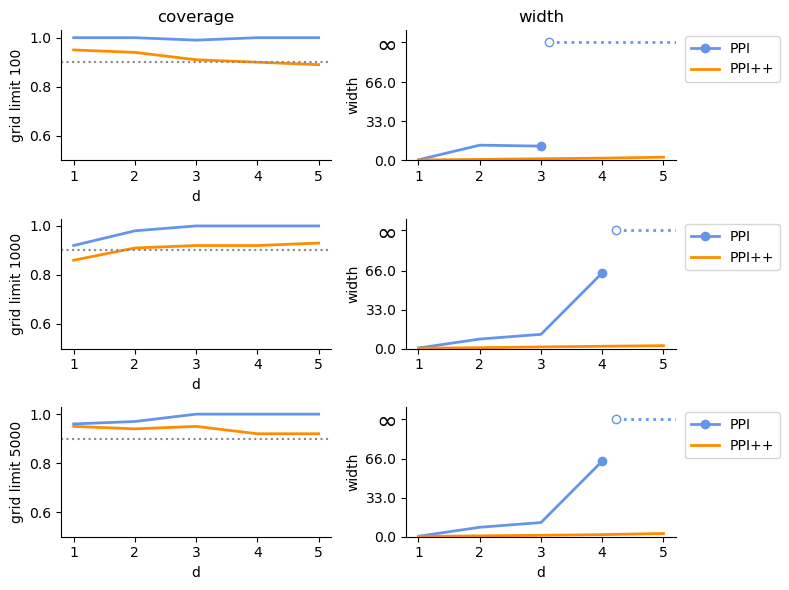

In [3]:
eff_color = "darkorange"
test_color = "cornflowerblue"
linewidth = 2

fig, axs = plt.subplots(
    nrows=grid_limits.shape[0], ncols=2, figsize=(8, 2 * grid_limits.shape[0])
)
all_median_sizes = np.median(sizes, axis=0)
inf_line_y = 100
for gs in range(grid_limits.shape[0]):
    cvg_ax = axs[gs, 0]
    sz_ax = axs[gs, 1]
    cvg_ax.plot(
        ds,
        includeds[:, :, gs].mean(axis=0),
        color=test_color,
        linewidth=linewidth,
        label="PPI",
    )
    cvg_ax.plot(
        ds,
        eff_includeds[:, :, gs].mean(axis=0),
        color=eff_color,
        linewidth=linewidth,
        label="PPI++",
    )
    cvg_ax.axhline(y=1 - alpha, linestyle="dotted", color="#888888")
    cvg_ax.set_yticks([0.6, 0.8, 1])
    median_sizes = np.median(sizes[:, :, gs], axis=0)
    median_eff_sizes = np.median(eff_sizes[:, :, gs], axis=0)
    if np.any(np.isinf(median_sizes)):
        largest_finite_index_sizes = np.where(np.isinf(median_sizes))[0][0] - 1
    else:
        largest_finite_index_sizes = -1
    if np.any(np.isinf(median_eff_sizes)):
        largest_finite_index_eff_sizes = (
            np.where(np.isinf(median_eff_sizes))[0][0] - 1
        )
    else:
        largest_finite_index_eff_sizes = -1
    max_y = max(
        median_sizes[largest_finite_index_sizes],
        median_eff_sizes[largest_finite_index_eff_sizes],
    )
    if np.any(np.isinf(median_sizes)):
        sz_line = sz_ax.plot(
            ds,
            median_sizes,
            color=test_color,
            linewidth=linewidth,
            markevery=[np.where(np.isinf(median_sizes))[0][0] - 1],
            marker="o",
            label="PPI",
        )
        first_inf = np.where(np.isinf(median_sizes))[0][0]
        first_inf_ax_coord = (first_inf - ds.min()) / (
            ds.max() - ds.min()
        ) + 0.03
        sz_ax.axhline(
            y=inf_line_y,
            xmin=first_inf_ax_coord,
            linewidth=linewidth,
            color=sz_line[0].get_color(),
            markevery=[0],
            marker="o",
            markerfacecolor="white",
            linestyle="dotted",
        )
    else:
        sz_line = sz_ax.plot(
            ds,
            median_sizes,
            color=test_color,
            linewidth=linewidth,
            label="PPI",
        )

    sz_ax.plot(
        ds,
        median_eff_sizes,
        color=eff_color,
        linewidth=linewidth,
        label="PPI++",
    )
    sz_ax.set_yticks([0.0, inf_line_y // 3, 2 * (inf_line_y // 3)])

    # Update yticks to include infinity symbol
    current_yticks = sz_ax.get_yticks()
    sz_ax.set_yticks(
        list(current_yticks) + [inf_line_y],
        list(map(str, current_yticks)) + ["$\infty$"],
    )
    # Modify the properties of the tick label at y = \infty
    for label in sz_ax.get_yticklabels():
        if (
            label.get_text() == "$\infty$"
        ):  # or any other condition that identifies the desired tick label
            label.set_fontsize(18)  # or any desired size

    cvg_ax.set_xlabel("d")
    cvg_ax.set_ylabel("grid limit " + str(grid_limits[gs]))
    cvg_ax.set_ylim([0.5, 1.03])
    sz_ax.legend(bbox_to_anchor=(1.01, 1.01))
    sz_ax.set_ylabel("width")
    sz_ax.set_ylim([0, 110])
axs[-1, 0].set_xlabel("d")
axs[-1, 1].set_xlabel("d")
axs[0, 0].set_title("coverage")
axs[0, 1].set_title("width")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig("./plots/eff-comparison.pdf")